<a href="https://colab.research.google.com/github/nmamie/ML4H_Project1/blob/master/ML4H_Project1_Task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Part 1: Heart Disease Prediction**

## **Preparation**

In [1]:
## basic packages
import pandas as pd
import numpy as np
from IPython.display import display

In [2]:
## setup
import warnings
warnings.filterwarnings("ignore")

path = "/content/drive/MyDrive/1) ETH/3) ML in Healthcare/5) Assignments/Project 1/Data Heart Failure/"

In [3]:
## data import
train_val_data = pd.read_csv(path + "train_val_split.csv")
test_data = pd.read_csv(path + "test_split.csv")

## **Q1: Exploratory Data Analysis**

In [4]:
## check dataset sample size & dimensionality
n = len(train_val_data)
p = len(train_val_data.columns)
print("No. of samples:  ", n)
print("No. of features: ", p)

No. of samples:   734
No. of features:  12


In [5]:
## check for missing data
train_val_data.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

**Conclusions:**
*   We have significantly more observations than variables. Hence, no further problems arise.
*   There are no missing values.

**Implications:**
*   None

In [6]:
## explore feature data types
train_val_data.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

Purely for plotting, we change the types of *FastingBS* and *HeartDisease* from "integer" to "object" in the following. This is changed back later.

In [7]:
train_val_data.loc[:,"FastingBS"] = train_val_data.loc[:,"FastingBS"].astype("object")
train_val_data.loc[:,"HeartDisease"] = train_val_data.loc[:,"HeartDisease"].astype("object")

AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


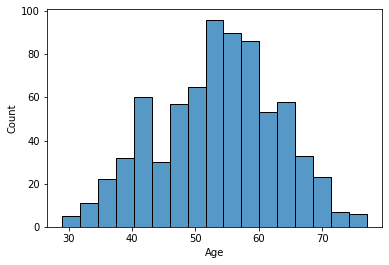

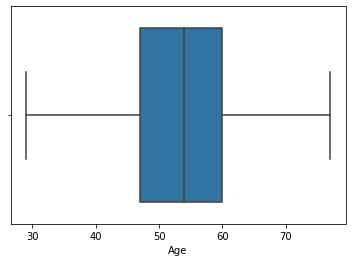

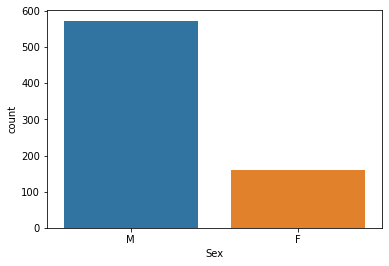

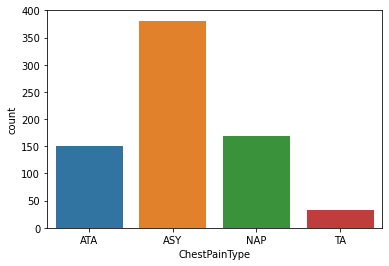

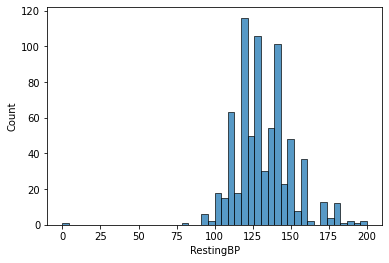

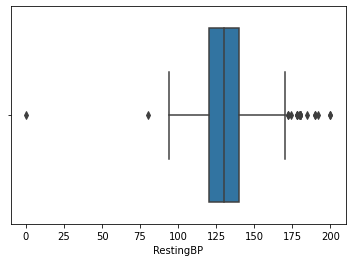

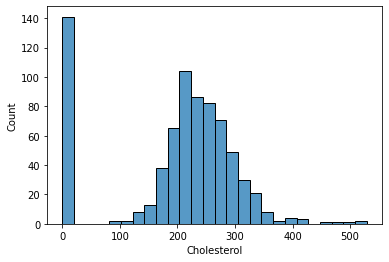

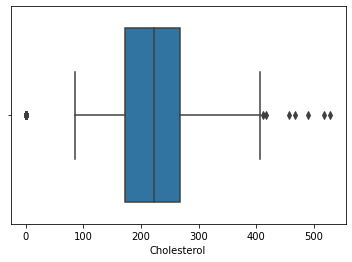

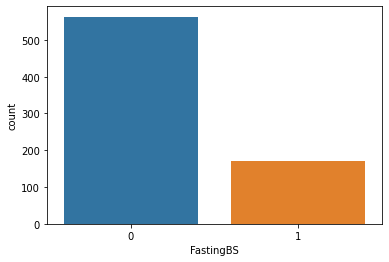

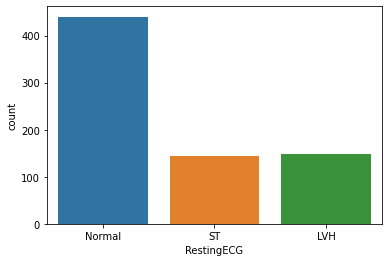

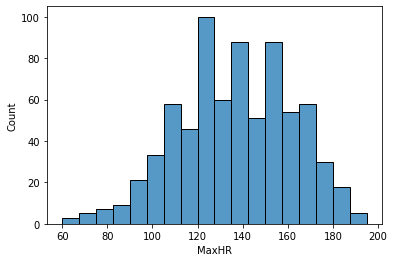

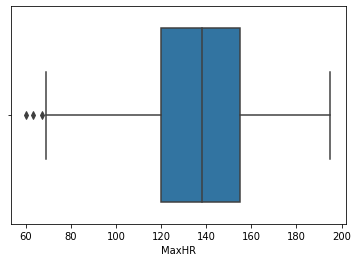

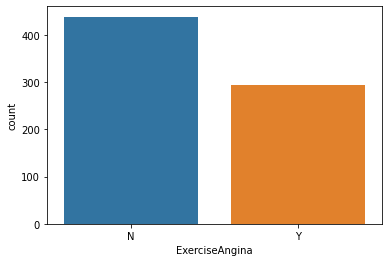

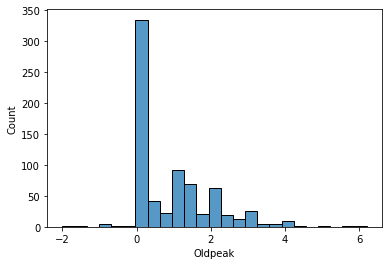

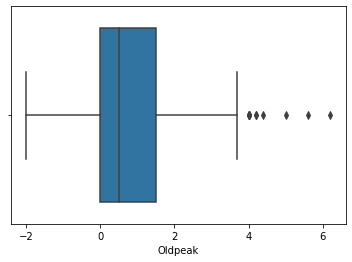

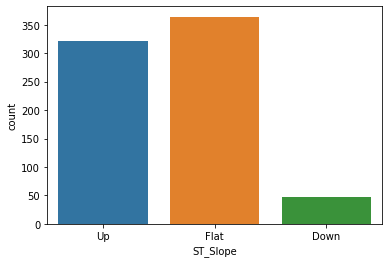

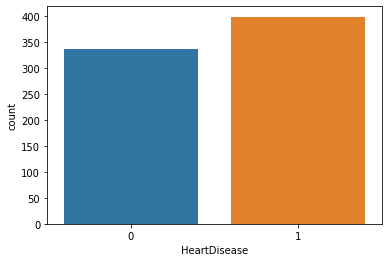

In [8]:
## explore distributions of continuous & categorical features
import seaborn as sn
import matplotlib.pyplot as plt

for ft in range(p):
  plt.figure()
  values = train_val_data.iloc[:,ft]
  if train_val_data.dtypes[ft]=="object":
    # histogram
    distr = sn.countplot(values)
    print(distr)
  else:
    # histogram
    distr = sn.histplot(values)
    print(distr)

    # boxplot
    plt.figure()
    boxplt = sn.boxplot(values)
    print(boxplt)

**Conclusions:**

1.   Some features are categorical, i.e. lack interpretability of differences in or ordering of their values.
2.   The dataset is imbalanced w.r.t. a couple of features, incl. *sex*, *chest pain type*, and *fasting blood sugar*. Importantly, however, the dataset is balanced w.r.t. the outcome variable, *heart disease*.
3.   *Cholesterol:* Many values of are exactly 0. Since virtually all values above 0 are >100, this seems highly unrealistic. Instead, we interpret this as missing values.
4.   *RestingBP:* There exist an observation with resting blood pressure of 0, which seems equally unrealistic. 

**Implications:**

1.   Create dummy variables or use one-hot encoding for the respective features.
2.  ...
3.   Since there are many observations with this anomaly, create a dummy variable indicating whether a patient's cholesterol measurement is missing or not.
4.   Since there is only 1 observation with this anomaly, 

## Analysis of Dependencies

To examine dependencies, we convert binary & categorical variables to dummy variables, and mark cholesterol levels of 0 as missing. Note the definition of the "default" values of categorical features:
*   *HeartDisease:* 0
*   *Sex*: M
*   *ChestPainType:* ASY
*   *FastingBS:* 0
*   *RestingECG:* Normal
*   *ExerciseAngina:* N
*   *ST_Slope:* Flat

In [9]:
## turn non-numerical variables into dummy variables
from sklearn.preprocessing import OneHotEncoder

cat_fts = train_val_data.select_dtypes(include=['object'])
cat_fts.drop(["HeartDisease"], axis=1, inplace=True)
cont_fts = train_val_data.select_dtypes(exclude=['object'])

enc = OneHotEncoder(drop=None, sparse=False)
cat_fts_trans = enc.fit_transform(cat_fts)
cat_fts_trans = pd.DataFrame(cat_fts_trans)
cat_fts_names = enc.get_feature_names_out()
cat_fts_trans.set_axis(cat_fts_names, axis=1, inplace=True)

train_val_data = pd.concat([train_val_data.loc[:,"HeartDisease"], cont_fts, cat_fts_trans], axis=1)

In [10]:
## if cholesterol = 0, then impute mean and set dummy to 1
train_val_data.loc[:,"Cholesterol"].replace(to_replace=0, value=np.nan, inplace=True)
train_val_data.insert(loc=4, column="Chol_NA", value=train_val_data.loc[:,"Cholesterol"].isna()*1)

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="mean")
train_val_data = pd.DataFrame(
    imputer.fit_transform(train_val_data),
    columns = train_val_data.columns)

In [11]:
# df w/o default variable values (reduced)
default_vars = ["Sex_M",
                "ChestPainType_ASY",
                "FastingBS_0",
                "RestingECG_Normal",
                "ExerciseAngina_N",
                "ST_Slope_Flat"]
train_val_data_red = train_val_data.drop(default_vars, axis=1, inplace=False)

## rename self-explanatory binary features
train_val_data_red.rename(columns={"FastingBS_1": "FastingBS",
                                   "ExerciseAngina_Y": "ExerciseAngina"}, inplace=True)

We compute rank correlations between non-categorical variables, since these cann capture also non-linear (monotonic) dependence structures. In case of binary variables (which includes the outcome variable *HeartDisease*), it corresponds to linear correlation.

Rank correlation:


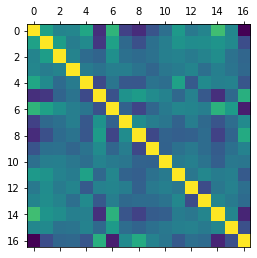

In [12]:
## compute rank correlations
rk_corr = train_val_data_red.corr(method="spearman")
print("Rank correlation:")
display(plt.matshow(rk_corr))

In [13]:
## significant rank correlations (|r|>0.4)
sig_corr = rk_corr[abs(rk_corr)>0.4]
sig_corr.replace(np.nan, "-", inplace=True)
sig_corr

,HeartDisease,Age,RestingBP,Cholesterol,Chol_NA,MaxHR,Oldpeak,Sex_F,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,FastingBS,RestingECG_LVH,RestingECG_ST,ExerciseAngina,ST_Slope_Down,ST_Slope_Up
HeartDisease,1.0,-,-,-,-,-0.413251,0.436762,-,-0.42536,-,-,-,-,-,0.502205,-,-0.631526
Age,-,1.0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
RestingBP,-,-,1.0,-,-,-,-,-,-,-,-,-,-,-,-,-,-
Cholesterol,-,-,-,1.0,-,-,-,-,-,-,-,-,-,-,-,-,-
Chol_NA,-,-,-,-,1.0,-,-,-,-,-,-,-,-,-,-,-,-
MaxHR,-0.413251,-,-,-,-,1.0,-,-,-,-,-,-,-,-,-0.410103,-,-
Oldpeak,0.436762,-,-,-,-,-,1.0,-,-,-,-,-,-,-,0.417747,-,-0.502399
Sex_F,-,-,-,-,-,-,-,1.0,-,-,-,-,-,-,-,-,-
ChestPainType_ATA,-0.42536,-,-,-,-,-,-,-,1.0,-,-,-,-,-,-,-,-
ChestPainType_NAP,-,-,-,-,-,-,-,-,-,1.0,-,-,-,-,-,-,-


**Conclusions**:
*   *HeartDisease* has a rank correlation of +0.4 or more with *ExerciseAngina* & *Oldpeak*, and of -0.4 or less with *MaxHR*, *ChestPainType_ATA*, and *ST_Slope_Up*.
*   Also, *ExerciseAngina* & *Oldpeak* are significantly positively associated. Further, *ExerciseAngina* & *MaxHR*, *Oldpeak* & *ST_Slope_Up*, and *ExerciseAngina* & *ST_Slope_Up* are significantly negatively correlated.
*   Hence, among the observed variables, ...

## **Q2: Logistic Lasso Regression**

When using regularization, we need to account for the fact that we introduced dummy variables. Specifically, we want to regularize the inclusion of entire variables, e.g. "Sex", and not certain categories, e.g. "Female", as this would introduce bias depending on the default category. To tackle this, we purposefully introduce all categories of categorical variables again and use Group Lasso. Altough this usually introduces multicollinearity, regularization serves to deal with this.

In [14]:
y_train_val = train_val_data.loc[:,"HeartDisease"]
X_train_val = train_val_data.drop("HeartDisease", axis=1)

Prior to the Lasso regression, we standardize continuous predictors. This usually improves accuracy and adequate variable selection, while only slightly affecting the interpretability of the coefficients.

In [15]:
## standardize continuous variables
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

cont_fts = ["Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak"]

X_train_val.loc[:,cont_fts] = pd.DataFrame(
    scaler.fit_transform(X_train_val.loc[:,cont_fts]),
    columns = cont_fts)

In [17]:
## train/validation-split
from sklearn.model_selection import train_test_split

train_size = 0.7
X_train, X_test, y_train, y_test = train_test_split(X_train_val, y_train_val, train_size=train_size, random_state=1)

ft_names = X_train.columns

In [19]:
#!pip install group-lasso
from group_lasso import LogisticGroupLasso

group_names = ["Age", "RestingBP", "Cholesterol", "Chol_NA", "MaxHR", "Oldpeak",
               "Sex", "ChestPain", "FastingBS", "RestingECG", "ExerciseAngina",
               "ST_Slope"]
group_sizes = [1, 1, 1, 1, 1, 1,
               2, 4, 2, 3, 2, 3]
n_groups = len(group_sizes)
groups = np.concatenate([size * [i] for i, size in enumerate(group_sizes)])

lgl = LogisticGroupLasso(
    groups = groups,
    group_reg = 0.1,
    l1_reg = 0.0,
    scale_reg = "inverse_group_size",
    subsampling_scheme = 1,
    supress_warning = True,
)

# estimate coefficients
lgl.fit(X_train, y_train)
coeffs = lgl.coef_[:, 1] - lgl.coef_[:, 0]
coeffs = pd.DataFrame(coeffs, index=ft_names)
coeffs.columns = ["Coef"]

# examine group norms
group_norms = np.array([[np.nan]]*n_groups)
for i in range(n_groups):
  group_coeffs = coeffs.loc[groups==i,:].values
  group_norms[i,:] = np.linalg.norm(group_coeffs, ord=1)

group_norms = pd.DataFrame(group_norms, index=group_names, columns=["Group Norm"])

# print result
coeffs.replace(0, "-", inplace=True)
group_norms.replace(0, "-", inplace=True)
display(coeffs)
display(group_norms)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


,Coef
Age,-
RestingBP,-
Cholesterol,-
Chol_NA,-
MaxHR,-
Oldpeak,-
Sex_F,-
Sex_M,-
ChestPainType_ASY,0.78326
ChestPainType_ATA,-0.462616


,Group Norm
Age,-
RestingBP,-
Cholesterol,-
Chol_NA,-
MaxHR,-
Oldpeak,-
Sex,-
ChestPain,1.56652
FastingBS,-
RestingECG,-


Since continuous predictors have been standardized, their coefficients are to be interpreted as the effect of a 1 standard deviation increase of the variable on the log-odds of having heart disease. For the respective variables, these are the following:

In [20]:
train_val_data.loc[:,cont_fts].std()

Age             9.421110
RestingBP      18.618490
Cholesterol    50.802178
MaxHR          25.334552
Oldpeak         1.082222
dtype: float64

We note that Lasso selects only variables which are relevant for prediction, but that there is no guarantee of it identifying the *causal* variables. In our case, ...